<a href="https://colab.research.google.com/github/stepanjaburek/quantum_social_science_lr/blob/main/stepan_colab_HCPC_13.1.25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data wrangling

#Setup

In [ ]:
!pip install scikit-learn-extra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from IPython.display import display

data = pd.read_excel("/content/pdf_search_results(1).xlsx")
metadata = pd.read_excel("/content/pdf_list(1).xlsx")



#Data cleaning

In [4]:
# Rename "Broekaert_2018" in metadata
metadata.loc[252, 'file_name'] = "Broekaert_2018_The Tacit 'Quantum' of Meeting the Aesthetic Sign; Contextualize, Entangle,2.pdf"
data.loc[252, 'filename'] = "Broekaert_2018_The Tacit 'Quantum' of Meeting the Aesthetic Sign; Contextualize, Entangle,2.pdf"
# Delete duplicit paper "Yukalov et al. - 2018 - Information processing by networks of quantum deci.pdf"
data = data.drop(1170)
# Delete paper "Yilmaz - 2017 - Quantum cognition models of ethical decision-makin.pdf" that is only present in data
data = data.drop(1166)
# Delete paper "Park_2016_Decision-making &amp quantum mechanical models of cognitive processing.pdf" that is only present in metadata
metadata = metadata.drop(892)

# Keywords

In [5]:
# Exclude authors and create df
df = data.drop(columns=[data.columns[i] for i in [1,2,4,16,30]])
# Exclude social science fields
df = df.drop(columns=df.columns[26:38])
# Possibly also Exclude "quantum" and "quantization"
df = df.drop(columns=df.columns[17:19])

# keep only papers with some non-zero values in the final columns we want to keep
df = df[df.iloc[:, 2:24].sum(axis=1) > 0]
df = df.reset_index(drop=True)

In [ ]:
[(i, list(df.keys())[i]) for i in range(len(df.keys()))]

In [ ]:
df

In [ ]:
# Or keeep only the authors
#df = data[data.columns[[1,2,4,16,30]]]

# Numbering the data for centroid extraction

In [8]:
metadata = metadata.reset_index()
metadata = metadata.rename(columns={'index': 'id'})
metadata['id'] = metadata['id'] + 1

df = df.reset_index()
df = df.rename(columns={'index': 'id'})
df['id'] = df['id'] + 1

# Scaling in the rows

In [ ]:
# create features for the pca
features = df.drop(['filename', 'id'], axis=1)
feature_names = features.columns


features = features.div(features.sum(axis=1), axis=0) # row normalization as Michael suggested, dividing the values by the sum of their row (paper)
#features = StandardScaler().fit_transform(features.T).T # Z-score standardization on transposed data to work in rows

features = pd.DataFrame(features, columns=feature_names)
features

# Scaling in the columns

In [ ]:
# create features for the pca
features = df.drop(['filename', 'id'], axis=1)
feature_names = features.columns

# scale with either z-score standardization or MinMax normalization
# features = StandardScaler().fit_transform(features) #Z-score
# features = MinMaxScaler().fit_transform(features) # MinMax

#features.iloc[:, 1:23] = (features.iloc[:, 1:23] > 0).astype(int) # binary >0
#features.iloc[:, 1:23] = (features.iloc[:, 1:23] > 4).astype(int) # binary >4

features = pd.DataFrame(features, columns=feature_names)
features

# Data analysis

#PCA

Explained variance ratio: [0.21805248 0.17690307 0.12289477 0.1014373  0.07854515 0.06598143
 0.05947673 0.04551538 0.04025369 0.03393288]


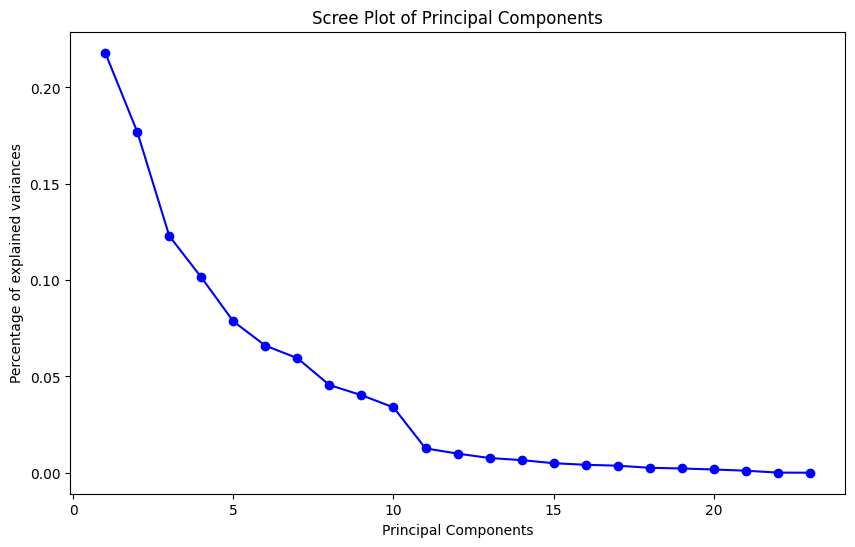

                         feature    PC   loading
entanglement        entanglement   PC1  0.825192
operator                operator   PC1 -0.536061
uncertainty          uncertainty   PC1 -0.092500
hamiltonian          hamiltonian   PC1 -0.080572
interference        interference   PC1 -0.074973
...                          ...   ...       ...
born's rule          born's rule  PC23  0.208514
complementarity  complementarity  PC23  0.208514
superposition      superposition  PC23  0.208514
wave function      wave function  PC23  0.208514
operator                operator  PC23  0.208514

[115 rows x 3 columns]
                     feature   PC   loading
entanglement    entanglement  PC1  0.825192
interference    interference  PC1 -0.074973
hamiltonian      hamiltonian  PC1 -0.080572
uncertainty      uncertainty  PC1 -0.092500
operator            operator  PC1 -0.536061
operator            operator  PC2  0.693404
entanglement    entanglement  PC2  0.384714
superposition  superposition  PC2 -0

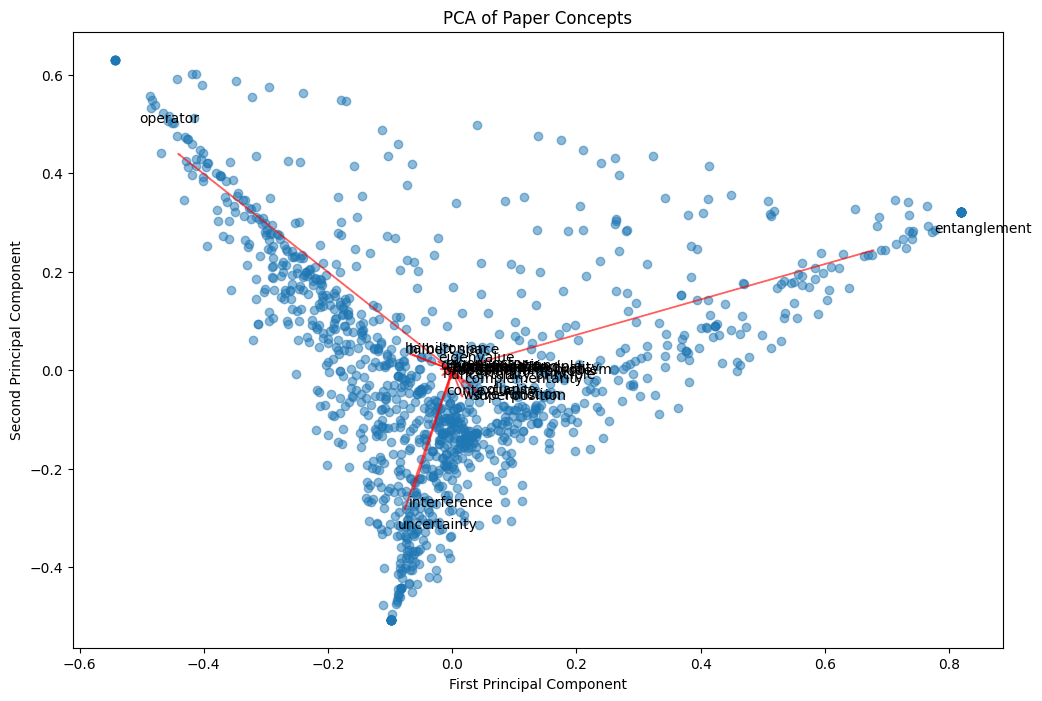

,feature,PC,loading
entanglement,entanglement,PC1,0.825192
interference,interference,PC1,-0.074973
hamiltonian,hamiltonian,PC1,-0.080572
uncertainty,uncertainty,PC1,-0.092500
operator,operator,PC1,-0.536061
operator,operator,PC2,0.693404
entanglement,entanglement,PC2,0.384714
superposition,superposition,PC2,-0.081865
interference,interference,PC2,-0.380147
uncertainty,uncertainty,PC2,-0.444301


In [86]:
pca = PCA()
pca_result = pca.fit_transform(features)
print("Explained variance ratio:", pca.explained_variance_ratio_[:10])

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, 'bo-')
plt.title('Scree Plot of Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Percentage of explained variances')
plt.show()

# Feature importance in components
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=features.columns
)

# Top 5 features per component
top_loadings = pd.DataFrame()
for pc in loadings.columns:
    top_5 = pd.DataFrame({
        'feature': loadings.index,
        'PC': pc,
        'loading': loadings[pc]
    })

    top_5 = top_5.reindex(top_5['loading'].abs().sort_values(ascending=False).index)
    top_5 = top_5.head(5)
    top_loadings = pd.concat([top_loadings, top_5])

print(top_loadings)

# PC1 and 2
pc12_loadings = top_loadings[top_loadings['PC'].isin(['PC1', 'PC2', 'PC3', 'PC4'])]
pc12_loadings = pc12_loadings.sort_values(['PC', 'loading'],
                                         ascending=[True, False])
print(pc12_loadings)

# PCA biplot
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

for i, feature in enumerate(features.columns):
    plt.arrow(0, 0,
              pca.components_[0, i]*max(abs(pca_result[:, 0])),
              pca.components_[1, i]*max(abs(pca_result[:, 1])),
              color='r', alpha=0.5)
    plt.text(pca.components_[0, i]*max(abs(pca_result[:, 0]))*1.15,
             pca.components_[1, i]*max(abs(pca_result[:, 1]))*1.15,
             feature)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Paper Concepts')
plt.show()
display(pc12_loadings)

How many PCs do we want? Literature says probalby between 80-90% of explained variance

Number of components needed to explain 80% of variance: 7


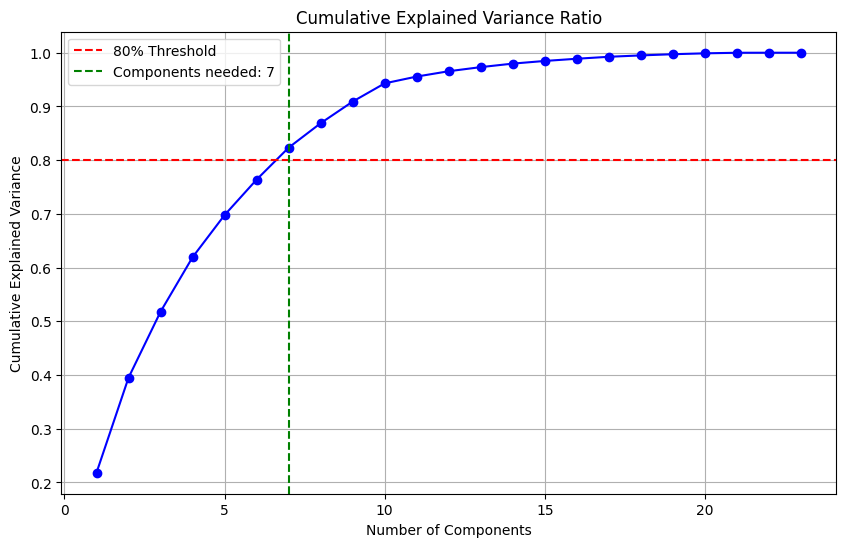


Cumulative explained variance for first 10 components:
Components 1-1: 0.218
Components 1-2: 0.395
Components 1-3: 0.518
Components 1-4: 0.619
Components 1-5: 0.698
Components 1-6: 0.764
Components 1-7: 0.823
Components 1-8: 0.869
Components 1-9: 0.909
Components 1-10: 0.943


In [88]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
# Find number of components needed for 80% variance (we can change this)
n_components_80 = np.argmax(cumulative_variance_ratio >= 0.8) + 1

print(f"Number of components needed to explain 80% of variance: {n_components_80}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1),
         cumulative_variance_ratio,
         'bo-')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
plt.axvline(x=n_components_80, color='g', linestyle='--',
            label=f'Components needed: {n_components_80}')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

# Print detailed variance explanation for first few components
print("\nCumulative explained variance for first 10 components:")
for i in range(10):
    print(f"Components 1-{i+1}: {cumulative_variance_ratio[i]:.3f}")

# Hierarchical Clustering on Principal Components (HCPC)

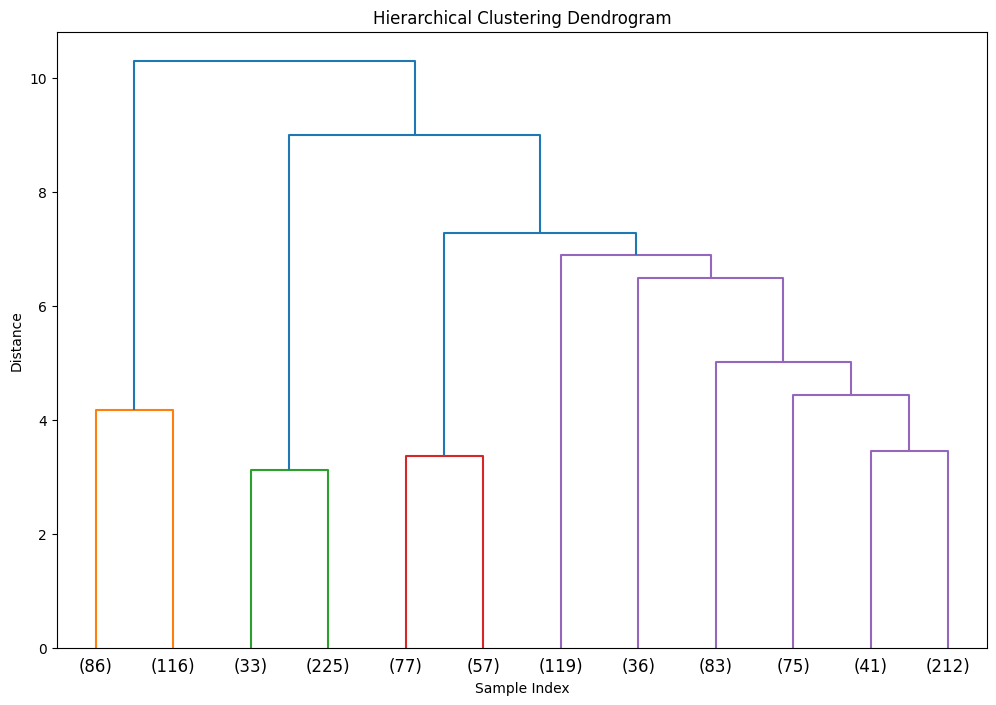

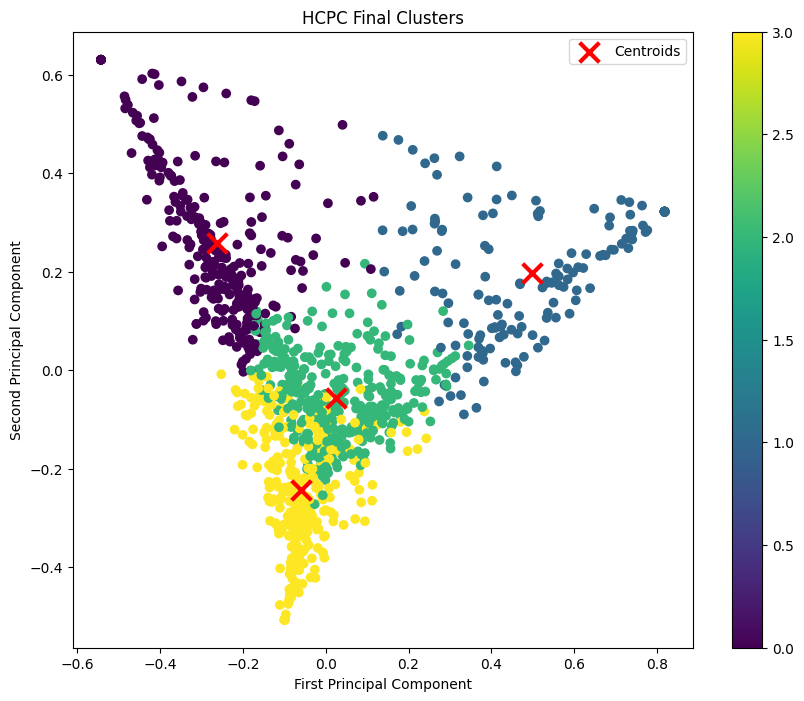

In [89]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# 1. Define how many PCs to use
n_components = 7 # I think we should use between 7 and 9 based on the PCA
selected_components = pca_result[:, :n_components]

# 2. Hierarchical clustering uisng Ward
linked = linkage(selected_components, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linked, truncate_mode='lastp', p=12)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# 3. Get initial clusters from hierarchical clustering
n_clusters = 4
hc_labels = fcluster(linked, n_clusters, criterion='maxclust')

# 4. K-means to finalize things
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(selected_components)
final_labels = kmeans.labels_

# Visualize final clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1],
                     c=final_labels, cmap='viridis')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
           c='red', marker='x', s=200, linewidths=3, label='Centroids')
plt.colorbar(scatter)
plt.title('HCPC Final Clusters')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.show()

In [90]:
# Get central papers from the HCPC
centroids_list = []
for i in range(n_clusters):
    distances = np.sum((selected_components - kmeans.cluster_centers_[i])**2, axis=1)
    top_indices = np.argsort(distances)[:10]  # specify N of papers

    cluster_papers = pd.DataFrame({
        'cluster': [i + 1] * 10,
        'rank': range(1, 11),
        'centroid_id': df['id'].iloc[top_indices].values,
        'distance': distances[top_indices]
    })
    centroids_list.append(cluster_papers)

centroids = pd.concat(centroids_list, ignore_index=True)
centerpapers = pd.merge(centroids, metadata, left_on='centroid_id', right_on='id', how='left')
centerpapers.to_csv('center_papers_hcpc.csv', index=False)

In [ ]:
# closer look at the final clusters
n_features = 5
characterization = []
for cluster in range(n_clusters):
    cluster_mask = final_labels == cluster
    cluster_center = np.mean(pca_result[cluster_mask], axis=0)

    feature_importance = np.abs(np.dot(cluster_center, pca.components_[:len(cluster_center)]))
    top_indices = np.argsort(feature_importance)[-n_features:]

    characterization.append({
        'cluster': cluster,
        'size': np.sum(cluster_mask),
        'top_features': list(zip(features.columns[top_indices],
                               feature_importance[top_indices]))
    })

final_characterization = pd.DataFrame(characterization)
display(final_characterization)

# K-means cluster analysis

In [ ]:
from sklearn.metrics import silhouette_score

def optimize_kmeans(data, max_clusters=10):
    silhouette_scores = []
    inertias = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, labels))
        inertias.append(kmeans.inertia_)

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(range(2, max_clusters + 1), inertias, 'bx-')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')

    ax2.plot(range(2, max_clusters + 1), silhouette_scores, 'rx-')
    ax2.set_xlabel('k')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')

    plt.tight_layout()
    plt.show()

    return silhouette_scores, inertias

scores, inertias = optimize_kmeans(pca_result[:, :9]) # number of dimensions taken into account while clustering

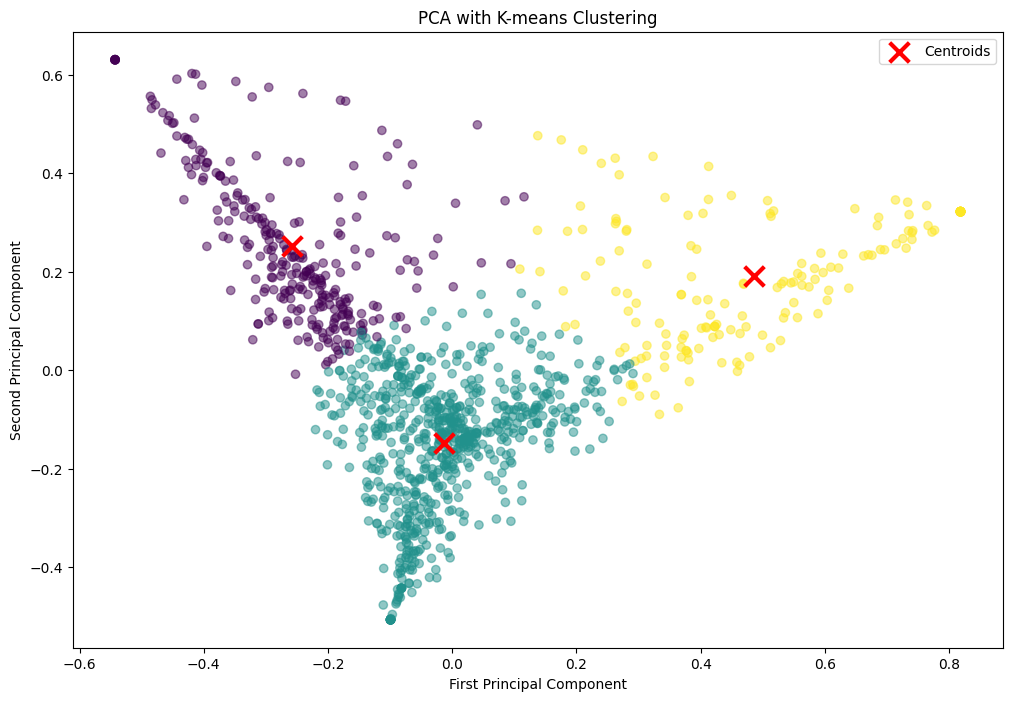

In [28]:
# Key parameters to alter
######################
n_clusters = 3 # number of clusters
kmeans = KMeans(n_clusters=n_clusters,
                random_state=42)
cluster_labels = kmeans.fit_predict(pca_result[:, :5]) # number of dimensions in the analysis

# Get the centroids
centroid_coords = kmeans.cluster_centers_

# Function to get top papers for each centroid
def get_top_papers(centroid_coord, pca_data, df, cluster_num, n_top=10): # number of central papers to extarct
    distances = np.sum((pca_data - centroid_coord)**2, axis=1)
    top_indices = np.argsort(distances)[:n_top]
    return pd.DataFrame({
        'cluster': [cluster_num + 1] * n_top,
        'rank': range(1, n_top + 1),
        'centroid_id': df['id'].iloc[top_indices].values,
        'distance': distances[top_indices]
    })

# Get top papers for each centroid
centroids_list = []
for i in range(n_clusters):
    cluster_papers = get_top_papers(centroid_coords[i], pca_result[:, :5], df, i) # here as well number of dimensions in the analysis
    centroids_list.append(cluster_papers)

centroids = pd.concat(centroids_list, ignore_index=True)

centerpapers = pd.merge(centroids, metadata, left_on='centroid_id', right_on='id', how='left')
centerpapers.to_csv('center_papers_means.csv', index=False)

# Viz
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
           c='red', marker='x', s=200, linewidths=3, label='Centroids')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA with K-means Clustering')
plt.legend()
plt.show()

# K-medoids cluster analysis

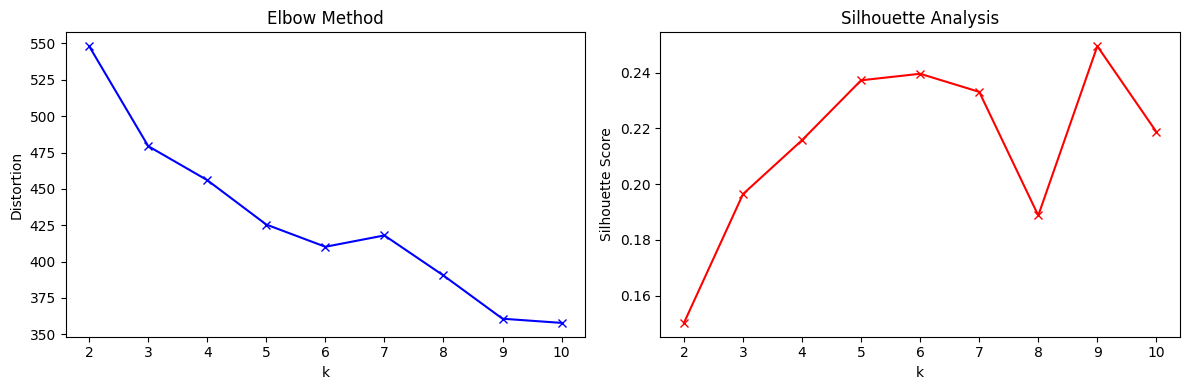

In [56]:
def find_optimal_clusters(data, max_clusters=10):
    silhouette_scores = []
    distortions = []

    for k in range(2, max_clusters + 1):
        pam = KMedoids(n_clusters=k,
                       random_state=42,
                       metric='euclidean',
                       method='alternate')
        labels = pam.fit_predict(data)
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)
        distortions.append(pam.inertia_)

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Elbow plot
    ax1.plot(range(2, max_clusters + 1), distortions, 'bx-')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Distortion')
    ax1.set_title('Elbow Method')

    # Silhouette plot
    ax2.plot(range(2, max_clusters + 1), silhouette_scores, 'rx-')
    ax2.set_xlabel('k')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')

    plt.tight_layout()
    plt.show()

    return silhouette_scores, distortions
scores, distortions = find_optimal_clusters(pca_result[:, :10]) # number of dimensions taken into account while clustering

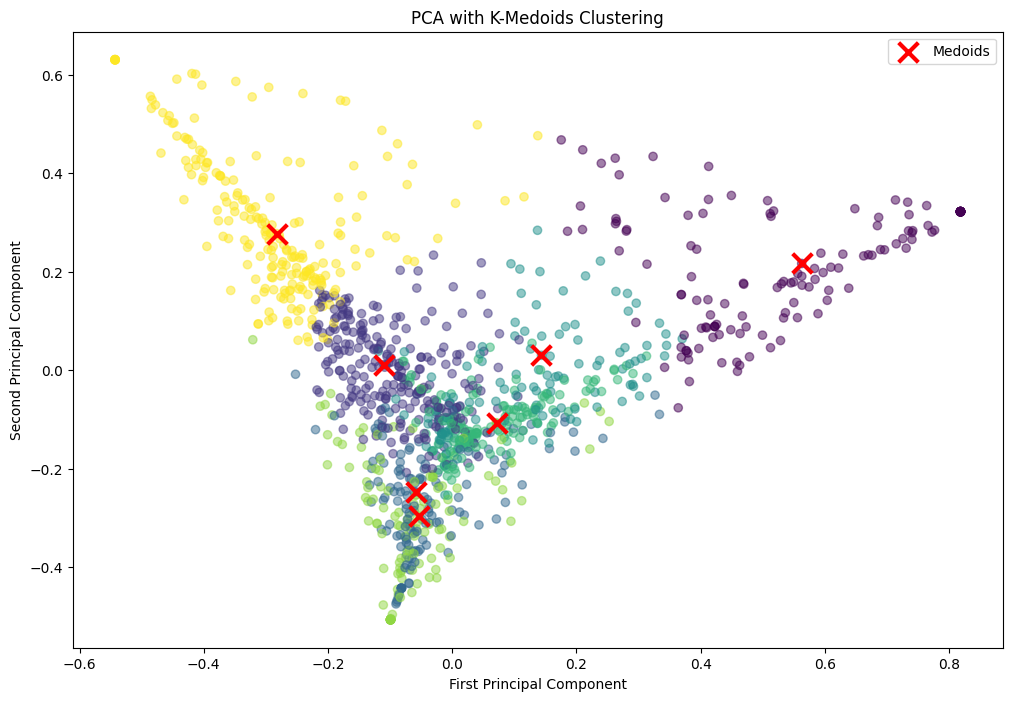

In [31]:
# Key parameters to alter
######################
n_clusters = 7 # number of clusters
pam = KMedoids(n_clusters=n_clusters,
               random_state=42,
               metric='euclidean',
               method='alternate')
cluster_labels = pam.fit_predict(pca_result[:, :5]) # number of dimensions in the analysis

# Get the medoid coordinates
medoid_indices = pam.medoid_indices_
medoid_coords = pca_result[medoid_indices, :5] # here as well number of dimensions in the analysis

# Function to get top papers for each centroid
def get_top_papers(centroid_coord, pca_data, df, n_top=10): # number of central papers to extarct
    distances = np.sum((pca_data - centroid_coord)**2, axis=1)
    top_indices = np.argsort(distances)[:n_top]
    return pd.DataFrame({
        'cluster': [pam.medoid_indices_.tolist().index(medoid_indices[i]) + 1] * n_top,
        'rank': range(1, n_top + 1),
        'centroid_id': df['id'].iloc[top_indices].values,
        'distance': distances[top_indices]
    })

# Get top papers for each centroid
centroids_list = []
for i, medoid_coord in enumerate(medoid_coords):
    cluster_papers = get_top_papers(medoid_coord, pca_result[:, :5], df)
    centroids_list.append(cluster_papers)

centroids = pd.concat(centroids_list, ignore_index=True)

centerpapers = pd.merge(centroids, metadata, left_on='centroid_id', right_on='id', how='left')
centerpapers.to_csv('center_papers_medoids.csv', index=False)

# Viz
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.scatter(pca_result[medoid_indices, 0], pca_result[medoid_indices, 1],
           c='red', marker='x', s=200, linewidths=3, label='Medoids')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA with K-Medoids Clustering')
plt.legend()
plt.show()

# Overlap of clusters
only limited use for now, but this should be extendable to anything else

In [32]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

# Z-Score K-means

In [50]:
n_clusters = 4
dims = [4,5,6,7,8,9,10]
z3means4, z3means5,z3means6, z3means7, z3means8, z3means9, z3means10 = [
    KMeans(n_clusters=n_clusters, random_state=42).fit_predict(pca_result[:, :d])
    for d in dims
]

In [51]:
import numpy as np

labels_dict = {
    '4 dims': z3means4,
    '5 dims': z3means5,
    '6 dims': z3means6,
    '7 dims': z3means7,
    '8 dims': z3means8,
    '9 dims': z3means9,
    '10 dims': z3means10
}

n = len(labels_dict)
ari_matrix = pd.DataFrame(np.zeros((n, n)),
                         columns=labels_dict.keys(),
                         index=labels_dict.keys())

for i in labels_dict.keys():
    for j in labels_dict.keys():
        ari = adjusted_rand_score(labels_dict[i], labels_dict[j])
        ari_matrix.loc[i,j] = round(ari, 3)

print("Adjusted Rand Index Scores between different dimensionalities:")
print(ari_matrix)

Adjusted Rand Index Scores between different dimensionalities:
         4 dims  5 dims  6 dims  7 dims  8 dims  9 dims  10 dims
4 dims    1.000   0.669   0.983   0.596   0.661   0.981    0.508
5 dims    0.669   1.000   0.664   0.858   0.552   0.670    0.567
6 dims    0.983   0.664   1.000   0.590   0.666   0.987    0.515
7 dims    0.596   0.858   0.590   1.000   0.552   0.596    0.629
8 dims    0.661   0.552   0.666   0.552   1.000   0.658    0.582
9 dims    0.981   0.670   0.987   0.596   0.658   1.000    0.507
10 dims   0.508   0.567   0.515   0.629   0.582   0.507    1.000


# MinMax K-Means

In [ ]:
n_clusters = 3
dims = [4,5,6,7,8,9,10]
m3means2, m3means3,m3means4, m3means5, m3means10 = [
    KMeans(n_clusters=n_clusters, random_state=42).fit_predict(pca_result[:, :d])
    for d in dims
]

In [ ]:
import numpy as np

labels_dict = {
    '2 dims': m3means2,
    '3 dims': m3means3,
    '4 dims': m3means4,
    '5 dims': m3means5,
    '10 dims': m3means10
}

n = len(labels_dict)
ari_matrix = pd.DataFrame(np.zeros((n, n)),
                         columns=labels_dict.keys(),
                         index=labels_dict.keys())

for i in labels_dict.keys():
    for j in labels_dict.keys():
        ari = adjusted_rand_score(labels_dict[i], labels_dict[j])
        ari_matrix.loc[i,j] = round(ari, 3)

print("Adjusted Rand Index Scores between different dimensionalities:")
print(ari_matrix)

Adjusted Rand Index Scores between different dimensionalities:
         2 dims  3 dims  4 dims  5 dims  10 dims
2 dims    1.000   0.984   0.403   0.422    0.371
3 dims    0.984   1.000   0.406   0.424    0.377
4 dims    0.403   0.406   1.000   0.499    0.304
5 dims    0.422   0.424   0.499   1.000    0.333
10 dims   0.371   0.377   0.304   0.333    1.000


In [ ]:
from IPython.display import display
display(ari_matrix)

,2 dims,3 dims,4 dims,5 dims,10 dims
2 dims,1.000,0.984,0.403,0.422,0.371
3 dims,0.984,1.000,0.406,0.424,0.377
4 dims,0.403,0.406,1.000,0.499,0.304
5 dims,0.422,0.424,0.499,1.000,0.333
10 dims,0.371,0.377,0.304,0.333,1.000


# Z-score K-Medoids

In [72]:
n_clusters = 7
dims = [4,5,6,7,8,9,10]
z3medoids4, z3medoids5,z3medoids6, z3medoids7, z3medoids8, z3medoids9, z3medoids10= [
    KMedoids(n_clusters=n_clusters, random_state=42, metric='euclidean',
             method='alternate').fit_predict(pca_result[:, :d])
    for d in dims
]

In [73]:
import numpy as np

labels_dict = {
    '4 dims': z3medoids4,
    '5 dims': z3medoids5,
    '6 dims': z3medoids6,
    '7 dims': z3medoids7,
    '8 dims': z3medoids8,
    '9 dims': z3medoids9,
    '10 dims': z3medoids10
}

n = len(labels_dict)
ari_matrix = pd.DataFrame(np.zeros((n, n)),
                         columns=labels_dict.keys(),
                         index=labels_dict.keys())

for i in labels_dict.keys():
    for j in labels_dict.keys():
        ari = adjusted_rand_score(labels_dict[i], labels_dict[j])
        ari_matrix.loc[i,j] = round(ari, 3)

print("Adjusted Rand Index Scores between different dimensionalities:")
print(ari_matrix)

Adjusted Rand Index Scores between different dimensionalities:
         4 dims  5 dims  6 dims  7 dims  8 dims  9 dims  10 dims
4 dims    1.000   0.566   0.546   0.555   0.535   0.471    0.433
5 dims    0.566   1.000   0.598   0.506   0.586   0.477    0.502
6 dims    0.546   0.598   1.000   0.662   0.720   0.580    0.487
7 dims    0.555   0.506   0.662   1.000   0.563   0.584    0.434
8 dims    0.535   0.586   0.720   0.563   1.000   0.557    0.474
9 dims    0.471   0.477   0.580   0.584   0.557   1.000    0.418
10 dims   0.433   0.502   0.487   0.434   0.474   0.418    1.000


In [ ]:
from IPython.display import display
display(ari_matrix)

,2 dims,3 dims,4 dims,5 dims,10 dims
2 dims,1.000,0.463,0.730,0.632,0.354
3 dims,0.463,1.000,0.458,0.388,0.469
4 dims,0.730,0.458,1.000,0.554,0.369
5 dims,0.632,0.388,0.554,1.000,0.372
10 dims,0.354,0.469,0.369,0.372,1.000


# Comparing K-Means and K-Medoids

---






In [74]:
# Compare each dimensionality pair
comparisons = {
    '4 dims': adjusted_rand_score(z3means4,z3medoids4),
    '5 dims': adjusted_rand_score(z3means5,z3medoids5),
    '6 dims': adjusted_rand_score(z3means6,z3medoids6),
    '7 dims': adjusted_rand_score(z3means7,z3medoids7),
    '8 dims': adjusted_rand_score(z3means8,z3medoids8),
    '9 dims': adjusted_rand_score(z3means9,z3medoids9),
    '10 dims': adjusted_rand_score(z3means10,z3medoids10)
}

# Create DataFrame
comparison_df = pd.DataFrame.from_dict(comparisons, orient='index', columns=['ARI Score'])
print("KMeans vs KMedoids comparison at different dimensions:")
print(comparison_df)

KMeans vs KMedoids comparison at different dimensions:
         ARI Score
4 dims    0.449566
5 dims    0.448479
6 dims    0.407292
7 dims    0.514396
8 dims    0.270255
9 dims    0.394592
10 dims   0.273027


In [ ]:
# Compare each dimensionality pair
comparisons = {
   '2 dims': adjusted_rand_score(m3means2, b3means2),
   '3 dims': adjusted_rand_score(m3means3, b3means3),
   '4 dims': adjusted_rand_score(m3means4, b3means4),
   '5 dims': adjusted_rand_score(m3means5, b3means5),
   '10 dims': adjusted_rand_score(m3means10, b3means10)
}

# Create DataFrame
comparison_df = pd.DataFrame.from_dict(comparisons, orient='index', columns=['ARI Score'])
print("KMeans vs KMedoids comparison at different dimensions:")
print(comparison_df)

KMeans vs KMedoids comparison at different dimensions:
         ARI Score
2 dims    0.040789
3 dims    0.006966
4 dims    0.017969
5 dims    0.028403
10 dims   0.066180


In [ ]:
# Compare each dimensionality pair
comparisons = {
   '2 dims': adjusted_rand_score(m3means2, z3means2),
   '3 dims': adjusted_rand_score(m3means3, z3means3),
   '4 dims': adjusted_rand_score(m3means4, z3means4),
   '5 dims': adjusted_rand_score(m3means5, z3means5),
   '10 dims': adjusted_rand_score(m3means10, z3means10)
}

# Create DataFrame
comparison_df = pd.DataFrame.from_dict(comparisons, orient='index', columns=['ARI Score'])
print("KMeans vs KMedoids comparison at different dimensions:")
print(comparison_df)

KMeans vs KMedoids comparison at different dimensions:
         ARI Score
2 dims    0.599007
3 dims    0.610429
4 dims    0.621733
5 dims    0.719408
10 dims   0.680496


In [ ]:
display(comparison_df)

,ARI Score
2 dims,0.599007
3 dims,0.610429
4 dims,0.621733
5 dims,0.719408
10 dims,0.680496
